##Implementation Of the DenseNet Model and Testing it on Cifer 10 dataset

In [ ]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/My Drive")

In [ ]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import datetime

In [ ]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler,TensorBoard,ReduceLROnPlateau,ModelCheckpoint

In [ ]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 10
l = 40
num_filter = 12
compression = 0.75
dropout_rate = 0

In [ ]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

from sklearn.model_selection import train_test_split
X_train , X_cv , y_train , y_cv = train_test_split(X_train , y_train , test_size = 0.20 , stratify = y_train)
print(X_train.shape , y_train.shape , X_cv.shape , y_cv.shape , X_test.shape , y_test.shape)

(40000, 32, 32, 3) (40000, 10) (10000, 32, 32, 3) (10000, 10) (10000, 32, 32, 3) (10000, 10)


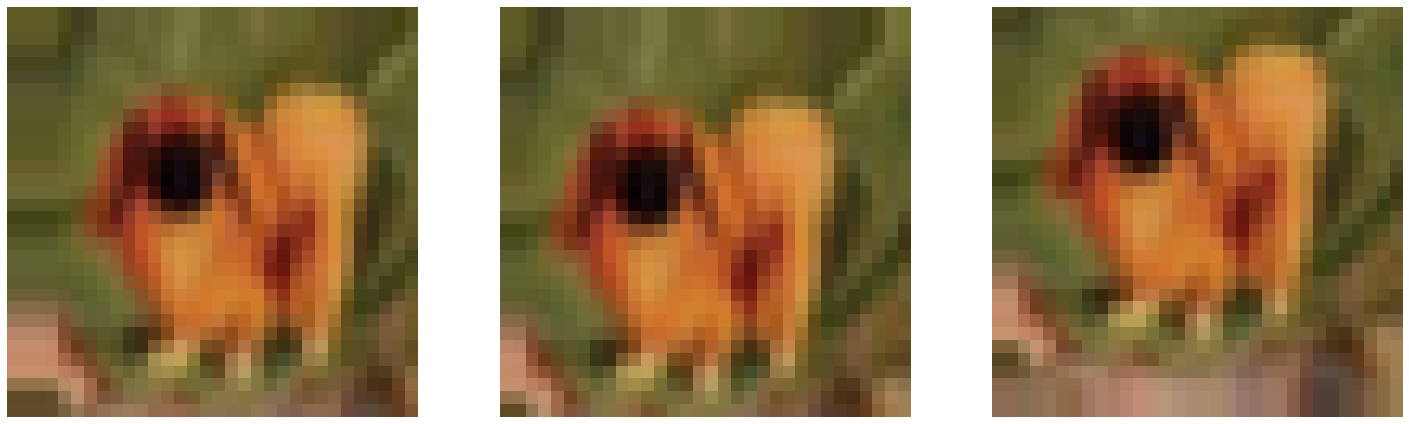

In [ ]:
#Lets see how images change when the augmentation affects are applied on them
# ImageDataGenerator horizontal and vertical shift
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1 )

# iterator
aug_iter = datagen.flow(X_train[:1], batch_size=1)

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,25))

# generate batch of images
for i in range(3):

	# convert to unsigned integers
	image = next(aug_iter)[0].astype('uint8')
 
	# plot image
	ax[i].imshow(image)
	ax[i].axis('off')

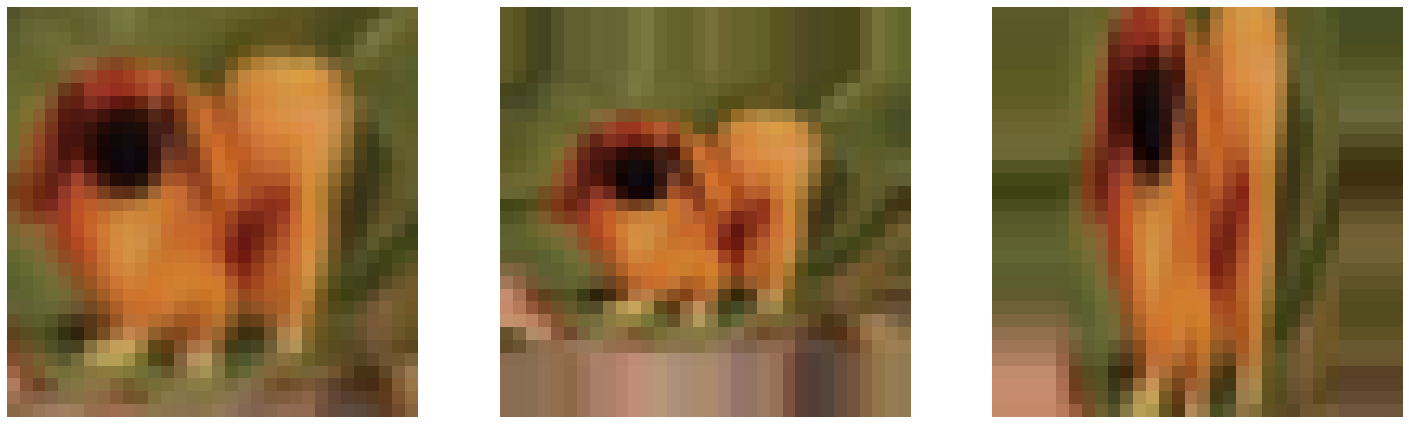

In [ ]:
# ImageDataGenerator zoom range
datagen = ImageDataGenerator(zoom_range=0.5)

# iterator
aug_iter = datagen.flow(X_train[:1], batch_size=1)

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,25))

# generate batch of images
for i in range(3):

	# convert to unsigned integers
	image = next(aug_iter)[0].astype('uint8')
 
	# plot image
	ax[i].imshow(image)
	ax[i].axis('off')

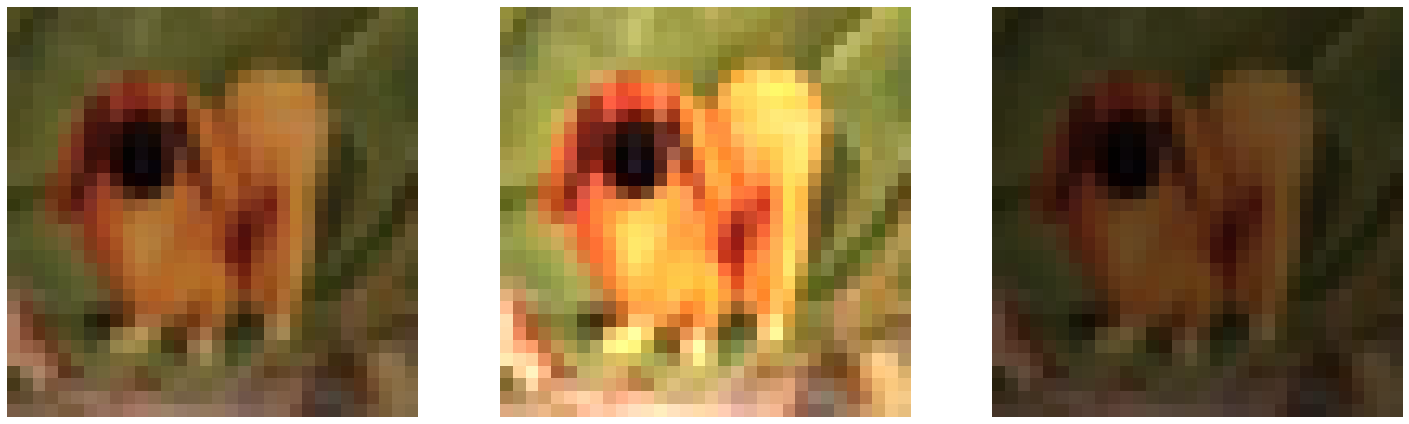

In [ ]:
# ImageDataGenerator brightness range
datagen = ImageDataGenerator(brightness_range=[0.4,1.5])

# iterator
aug_iter = datagen.flow(X_train[:1], batch_size=1)

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,25))

# generate batch of images
for i in range(3):

	# convert to unsigned integers
	image = next(aug_iter)[0].astype('uint8')
 
	# plot image
	ax[i].imshow(image)
	ax[i].axis('off')

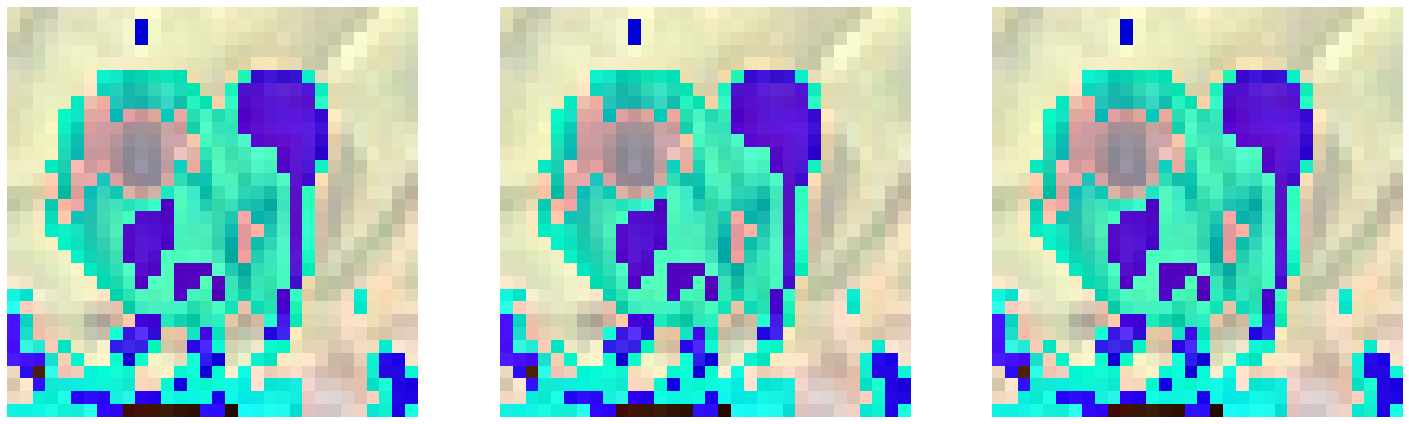

In [ ]:
# ImageDataGenerator brightness range
datagen = ImageDataGenerator(featurewise_center=True )
datagen.fit(X_train)
# iterator
aug_iter = datagen.flow(X_train[:1], batch_size=1)

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,25))

# generate batch of images
for i in range(3):

	# convert to unsigned integers
	image = next(aug_iter)[0].astype('uint8')
 
	# plot image
	ax[i].imshow(image)
	ax[i].axis('off')

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


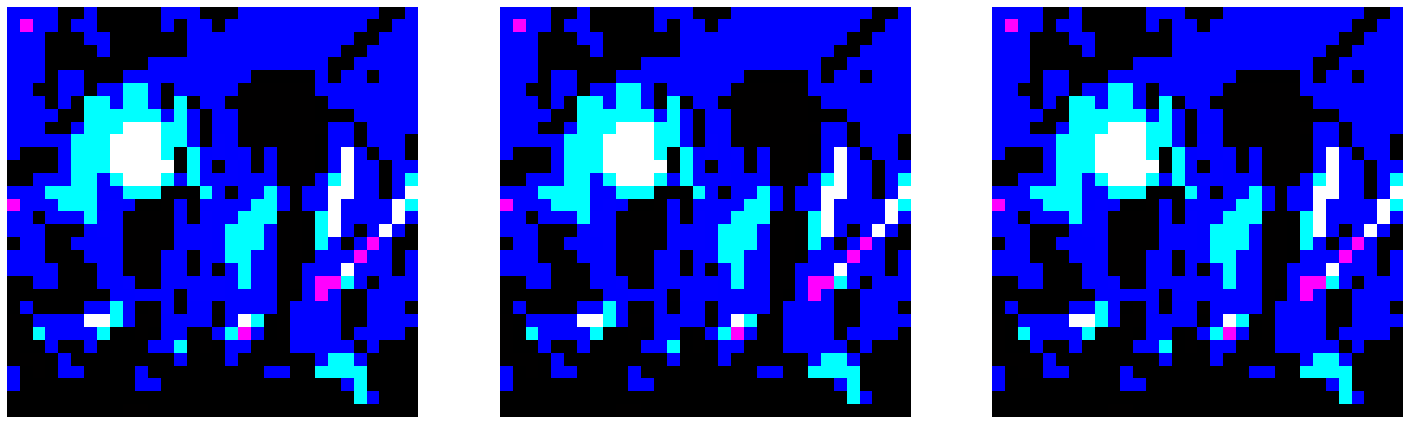

In [ ]:
# ImageDataGenerator brightness range
datagen = ImageDataGenerator(featurewise_std_normalization=True )
datagen.fit(X_train)
# iterator
aug_iter = datagen.flow(X_train[:1], batch_size=1)

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,25))

# generate batch of images
for i in range(3):

	# convert to unsigned integers
	image = next(aug_iter)[0].astype('uint8')
 
	# plot image
	ax[i].imshow(image)
	ax[i].axis('off')

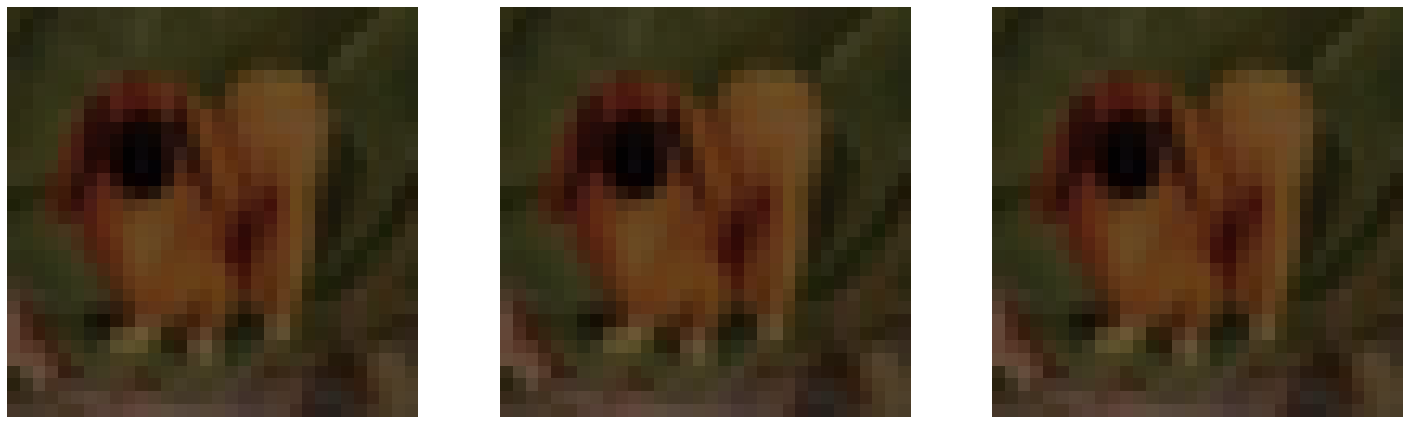

In [ ]:
# ImageDataGenerator brightness range
datagen = ImageDataGenerator(rescale = 0.5 )
datagen.fit(X_train)
# iterator
aug_iter = datagen.flow(X_train[:1], batch_size=1)

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,25))

# generate batch of images
for i in range(3):

	# convert to unsigned integers
	image = next(aug_iter)[0].astype('uint8')
 
	# plot image
	ax[i].imshow(image)
	ax[i].axis('off')

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


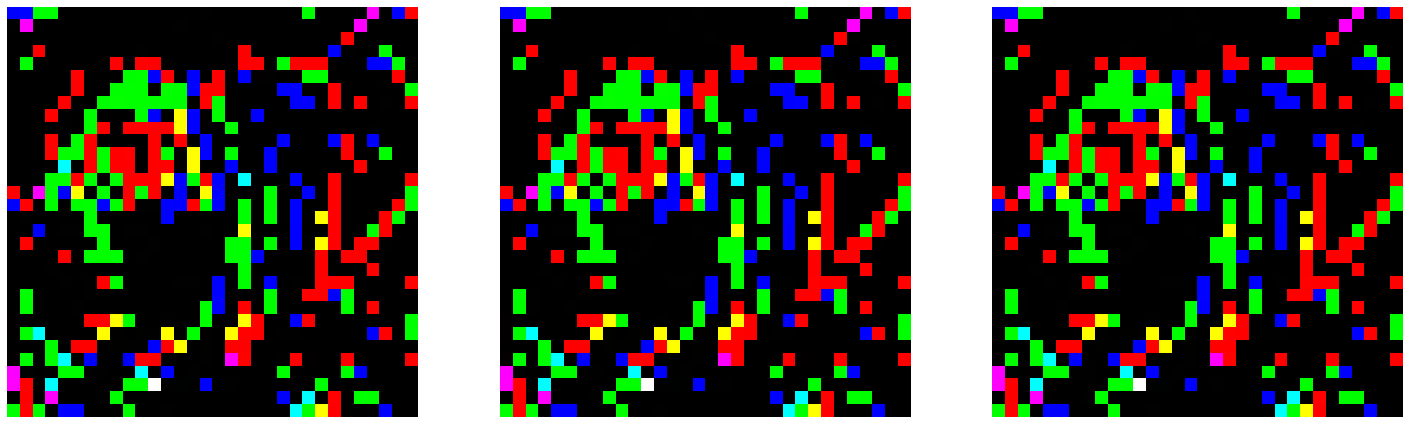

In [ ]:
# ImageDataGenerator brightness range
datagen = ImageDataGenerator(zca_whitening=True )
datagen.fit(X_train)
# iterator
aug_iter = datagen.flow(X_train[:1], batch_size=1)

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,25))

# generate batch of images
for i in range(3):

	# convert to unsigned integers
	image = next(aug_iter)[0].astype('uint8')
 
	# plot image
	ax[i].imshow(image)
	ax[i].axis('off')

In [ ]:
# Dense Block
compression = 1

def denseblock(input, num_filter = 12, dropout_rate = 0):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [ ]:
num_filter = 17
dropout_rate = 0
l = 13
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)


model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 17)   459         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 17)   68          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 17)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=25,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range = [0.4 ,1.5],
    featurewise_std_normalization = True,
    )
datagen.fit(X_train)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
train_iter = datagen.flow(X_train, y_train, batch_size=128)
cv_iter = datagen.flow(X_cv, y_cv, batch_size=128)
#test_iter = datagen.flow(X_test, y_test, batch_size=128)


In [ ]:
def scheduler(epoch , lr):
  if epoch > 1 and epoch % 15 == 0:
    return lr*0.50
  else :
    return lr
lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",mode = 'min',factor = 0.5,Patience = 2,verbose=1)
filepath="/content/drive/MyDrive/DenseNet_Model/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint_callback = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1)

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=15,
    verbose=1,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

In [ ]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.01),
              metrics=['accuracy'])

model.fit(train_iter, steps_per_epoch=len(train_iter),epochs = 100,validation_data=cv_iter,callbacks=[lr_plateau,
                                                                                                      earlystop,
                                                                                                      LearningRateScheduler(scheduler,verbose=1)])

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
352/352 [==============================] - 99s 256ms/step - loss: 2.3721 - accuracy: 0.1969 - val_loss: 2.2166 - val_accuracy: 0.2380

Epoch 00001: saving model to /content/drive/MyDrive/DenseNet_Model/weights-01-0.2380.hdf5
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
352/352 [==============================] - 85s 242ms/step - loss: 1.7562 - accuracy: 0.3505 - val_loss: 1.9545 - val_accuracy: 0.3162

Epoch 00002: saving model to /content/drive/MyDrive/DenseNet_Model/weights-02-0.3162.hdf5
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
352/352 [==============================] - 85s 242ms/step - loss: 1.5283 - accuracy: 0.4383 - val_loss: 1.6096 - val_accuracy: 0.4250

Epoch 00003: saving model to /content/drive/MyDrive/DenseNet_Model/weights-03-0.4250.hdf5
Epoch 4/100

Epoch 00004: LearningRat

In [ ]:
model.load_weights('/content/drive/MyDrive/DenseNet_Model/weights-78-0.8906.hdf5')

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])

In [ ]:
model.fit(train_iter, steps_per_epoch=len(train_iter),epochs = 100,validation_data=cv_iter,callbacks=[lr_plateau,earlystop,
                                                                                                       LearningRateScheduler(scheduler,verbose=1)
                                                                                                    ])

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
313/313 [==============================] - 79s 251ms/step - loss: 0.2723 - accuracy: 0.9048 - val_loss: 0.2713 - val_accuracy: 0.9044
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
313/313 [==============================] - 79s 252ms/step - loss: 0.2622 - accuracy: 0.9100 - val_loss: 0.2588 - val_accuracy: 0.9084
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
313/313 [==============================] - 79s 254ms/step - loss: 0.2512 - accuracy: 0.9140 - val_loss: 0.2734 - val_accuracy: 0.9043
Epoch 4/100

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
313/313 [==============================] - 80s 255ms/step - loss: 0.2512 - accuracy: 0.9123 - val_loss: 0.2770 - val_accuracy: 0.9046
Epoch 5/100

Epoch 00005: LearningRateScheduler reducing learning rate to 0.

In [ ]:
test_iter = datagen.flow(X_test, y_test, batch_size=128)

In [ ]:
score = model.evaluate(test_iter, steps=len(test_iter), verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.9028000235557556


The model ran for 82+36 =  118 epochs